# Without sWeights: `common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25`

# Fit the complete data
    
TWO TASKS: (\# iterations: $\approx$1000)
- **Mode 1**: The fixed (=tail) parameters of the $D^*\pi\pi\pi$ are randomly changed within their uncertainty.
For the fixed parameters $p\in\{\alpha_L, \alpha_R, n_L, n_R\}$ of uncertainty $\Delta p$ and nominal value $p_0$:
$$p=p_0+\mathcal{N}(\mu=0, \sigma = \Delta p)$$
    The ratio of yield $\frac{n_{B^0 \to D^{*-} K^+ \pi^+ \pi^-}}{n_{B^0 \to D^{*-} \pi^+ \pi^+ \pi^-}}$ and the parameters of the $D^*Kpipi$ fit are still fixed. The fit on is performed again with those values.
    The results of the fits are stored in a JSON file, in particular the signal yield $n_{sig}$.

- **Mode 2**: The same is done with the ratio of yield $\frac{n_{B^0 \to D^{*-} K^+ \pi^+ \pi^-}}{n_{B^0 \to D^{*-} \pi^+ \pi^+ \pi^-}}$ and the parameters of the $D^*Kpipi$ fit. A  fit is performed on $D^*\pi\pi\pi$.
The results of the fits are stored in a JSON file, in particular the signal yield $n_{sig}$.


Fit on $m(B^0_s)$ with:
- Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
- Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
- Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
- Combinatorial background (exponential)

## Import

In [1]:
import zfit
import json
import numpy as np
import timeit

from numpy.random import normal

from math import sqrt

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_saved_root, load_data, add_constr_Dst, json_to_latex_table, retrieve_params, format_previous_params
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from plot.tool import save_file, set_text_LHCb
from fit import launch_fit, define_zparams, save_params, sum_crystalball, check_fit
from variables import name_params, name_params_KPiPi

Welcome to JupyROOT 6.22/02


In [2]:
name_params_KPiPi_print = {}
for key, value in name_params_KPiPi.items():
    name_params_KPiPi_print[key+'_Kpipi'] = name_params_KPiPi[key]

In [3]:
#name_data = 'common_Dst_constr'
#name_data_B0toDstDs = 'common_B0toDstDs_Dst_constr'

name_data = 'common_Dst_constrHEP'
name_data_B0toDstDs = 'common_B0toDstDs_Dst_constrHEP'

name_data_Dstto3pi = 'common_Dstto3piHEP' # same as sWeights as the unconstrained case

name_BDT = 'gradient_bkgHighB0M'

name_data_MC = 'MC_constr_opposedCB_sharedMean'
name_data_KPiPi = "data_KPiPi_constr"

BDT = -1.25

In [4]:
n_iters = 400
start = 0
mode = 2
k = str(mode)
n_shows = 2 

In [5]:
if n_shows !=0:
    show_index_list = list(range(start, n_iters, int((n_iters-start)/n_shows)))
    print(show_index_list)
else:
    show_index_list= []

[379, 389, 399]


## Load

### Json files

In [6]:
name_data_BDT = f"{name_data}_BDT{BDT}"
name_data_B0toDstDs_BDT = f"{name_data_B0toDstDs}_BDT{BDT}"

# Fixed alphaL, alphaR and nL
common_params = retrieve_params(name_data, name_folder=name_data)
# Fixed nR
MC_params = retrieve_params(name_data_MC, name_folder='MC')

# B0->DstKPiPi
Kpipi_params = retrieve_params(name_data_KPiPi, name_folder='data_KPiPi') # already in MeV 

# common with BDT cut (for startning values of the fit)
pipipi_params = format_previous_params(retrieve_params(name_data_BDT, name_folder=name_data), True)
# B0->DstDs with BDT cut (for the B0->DstDs PDF shape)
DstDs_params = format_previous_params(retrieve_params(name_data_B0toDstDs_BDT, name_folder=name_data_B0toDstDs), True) 

Load 
- `f_params_dict['1']` - the fixed parameters that will be changed in **mode 1**
- `f_params_dict['2']`  - the fixed parameters that will be changed in **mode 2**

In [7]:
f_params_dict = {}
f_params_dict['1'] = ['alphaL', 'alphaR', 'nL', 'nR']
f_params_dict['2'] = ['r_bkgK', 
                      'muL_Kpipi', 'muR_Kpipi', 'nL_Kpipi', 'nR_Kpipi',
                      'alphaL_Kpipi', 'alphaR_Kpipi',
                      'sigmaL_Kpipi', 'sigmaR_Kpipi', 'fraction_Kpipi']


In [8]:
f_params = {} # fixed parameters

for param in 'alphaL', 'alphaR', 'nL', 'r_bkgK':
    f_params[param] = {}
    f_params[param]['val'] = common_params[param] # nominal value
    f_params[param]['std'] = common_params[param + '_err'] # standard deviation

f_params['nR'] = {}
f_params['nR']['val'] = MC_params['nR_MC']
f_params['nR']['std']  = MC_params['nR_MC_err']

for param in 'muL', 'muR', 'nL', 'nR', 'alphaR', 'alphaL', 'sigmaL', 'sigmaR', 'fraction':
    f_params[param+'_Kpipi'] = {}
    f_params[param+'_Kpipi']['val'] = Kpipi_params[param]
    f_params[param+'_Kpipi']['std'] = Kpipi_params[param+'_err']


In [9]:
df = load_saved_root('common_'+name_BDT, name_folder='common', vars=['B0_M', 'Dst_M', 'BDT'])
df = df.query(f"BDT > {BDT}")
df = add_constr_Dst(df)

/afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_gradient_bkgHighB0M.root


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data_cut_-1.25


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Candidates / (0.06)'>)

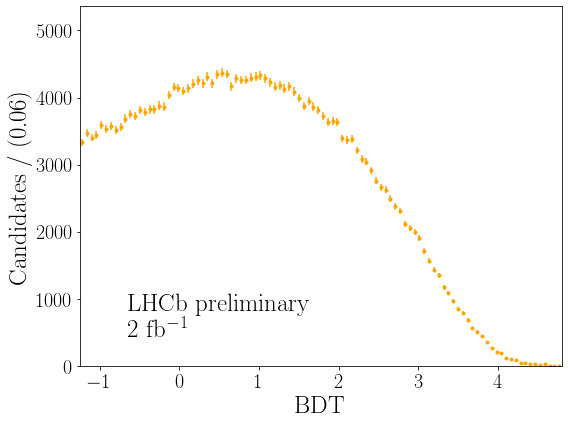

In [10]:
h.plot_hist_particle({'data\_cut\_-1.25': df},'BDT',
              n_bins = 100, mode_hist = False, colors=['orange', 'cyan'], pos_text_LHC=[0.1,0.2,'left'])

## Range of the variables

### Constrained $m(D^* 3\pi)$ of the `common` data

In [10]:
var = 'Dst_constr_B0_M'
low = 5150.
high = 5545.

## LOOP

In [11]:
def same_sign(a, b):
    return (a>0 and b>0) or (a<0 and b<0)

In [14]:
# for i in range(start, n_iters):
for i in indexes:
    verbose = i in show_index_list
    name_iter = name_data_BDT + f'u{mode};{i}'

    print('iter:', i)

    r_params = {} # fixed parameters, changed or not

    for param in f_params:
        if param in f_params_dict[k]:
            r_params[param] = f_params[param]['val'] + normal(0, f_params[param]['std'])
            # the generated value should have the same sign as the nominal value
            while not same_sign(r_params[param], f_params[param]['val']):
                r_params[param] = f_params[param]['val'] + normal(0, f_params[param]['std'])
        else:
            r_params[param] = f_params[param]['val']


    ### FIT ON DstPiPiPi ============================================================     
    ## Starting point of the fit ...............

    n_events_B0_M = len(df.query(f'{var} > {low} and {var} < {high}'))   

    initial_values = {
        # Signal        
        'mu'       :{ 'value': pipipi_params['mu']           , 'low': 5279.-3.                      , 'high': 5279.+3.             , 'floating': True},
        'sigmaL'   :{ 'value': pipipi_params['sigmaL']       , 'low': 5.                            , 'high': 20.                 , 'floating': True},
        'sigmaR'   :{ 'value': pipipi_params['sigmaR']       , 'low': 10.                           , 'high': 30.               , 'floating': True},
        'frac'     :{ 'value': pipipi_params['frac']         , 'low': 0.1                           , 'high': 1.                   , 'floating': True},
        'n_sig'    :{ 'value': pipipi_params['n_sig']        , 'low': pipipi_params['n_sig']*0.1    , 'high': n_events_B0_M        , 'floating': True},
        # Combinatorial background        
        'lambda'   :{ 'value': pipipi_params['lambda']       , 'low': -0.1                          , 'high': -0.0000000001        , 'floating': True},
        'n_bkg'    :{ 'value': pipipi_params['n_bkg']        , 'low': 0                             , 'high': n_events_B0_M        , 'floating': True},
        # Background decay D*Kpipi    
    }

    # Fixed parameters:
    for param, value_param in r_params.items():
        initial_values[param] = {}
        initial_values[param]['value'] = value_param
        initial_values[param]['floating'] = False

    # B0 -> D* Ds distribution
    for vari in 'mu', 'sigma', 'n_sig' :
        initial_values[f'{vari}_Ds'] = {'value': DstDs_params[f'{vari}_B0Ds'], 'low': None, 'high': None, 'floating': False}

    ## Observable and variables .................
    obs = zfit.Space("x", limits=(low, high))

    zparams = define_zparams(initial_values, num=i)

    mult = lambda r, n: r*n
    zparams["n_bkgK"] = zfit.ComposedParameter(f"n_bkgK{i}", mult, params=[zparams['r_bkgK'],zparams['n_sig']])    

    ## PDFs .....................................
    model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                              zparams['sigmaL'], zparams['sigmaR'],
                                                              zparams['frac'], obs,                                                          
                                                              zparams['alphaL'], zparams['alphaR'], 
                                                              zparams['nL'], zparams['nR']
                                                             )


    gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

    model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_Kpipi'], zparams['muR_Kpipi'], 
                                                              zparams['sigmaL_Kpipi'], zparams['sigmaR_Kpipi'],
                                                              zparams['fraction_Kpipi'], obs,
                                                              zparams['alphaL_Kpipi'], zparams['alphaR_Kpipi'], 
                                                              zparams['nL_Kpipi'], zparams['nR_Kpipi'])

    exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


    model_S_ext = model_S.create_extended(zparams['n_sig'])
    exp_ext = exponential.create_extended(zparams['n_bkg'])
    gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_Ds'])
    model_K_ext = model_K.create_extended(zparams['n_bkgK'])

    model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac
    data = zfit.Data.from_pandas(df[var], obs=obs)

    ## Do the fit ...............................
    start = timeit.default_timer()
    result, params = launch_fit(model, data, extended=True, verbose=verbose)
    result, params = launch_fit(model, data, extended=True, verbose=verbose)
    stop = timeit.default_timer()
    print('Time to do the fit: ', stop - start) 
    fit_ok = check_fit(result, verbose=True)

    ## Plot and save the fit ....................
    if verbose:
        plot_hist_fit_particle(df, var, models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, model_K_ext,exp_ext],
                               name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$',
                                              '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                               cut_BDT=BDT,
                               obs=obs, n_bins = 100,mode_hist = False,
                               name_data = name_iter+'_detail', name_folder=name_data_BDT,
                               colors=['b', 'g', 'r', 'cyan', 'y'],
                               params=params,name_params=name_params,
                               fontsize_leg=13.5, show_chi2=True,
                               colWidths=[0.06,0.01,0.05,0.06]
                              )
        name_data_plot = name_data
        plot_hist_fit_particle(df, var, models = [model,model_S_ext, gaussian_B0Ds_ext, model_K_ext,exp_ext],
                               name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$',
                                              '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                               cut_BDT=BDT,
                               obs=obs, n_bins = 100,mode_hist = False,
                               name_data = name_iter, name_folder=name_data_BDT,
                               colors=['b', 'g', 'r', 'cyan', 'y'],
                               fontsize_leg=13.5, pos_text_LHC='right') 



    save_params(params, name_iter, True, 
                {'fit_ok': fit_ok, 'info_fit':str(result.info['original']), 'info_params': str(params),
                 'r_params': r_params}, 
                name_folder=name_data_BDT)

iter: 508
Time to do the fit:  11.927252399967983
parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25u2;508_params.json
iter: 547
Time to do the fit:  9.78338816203177
parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25u2;547_params.json
iter: 674
Time to do the fit:  10.059340364066884
parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25u2;674_params.json
iter: 708
Time to do the fit:  10.671009288867936
parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25u2;708_params.json
iter: 751
Time to do the fit:  10.536552269943058
parameters s

## Redo some fits

In [12]:
mode = 1
indexes = [440, 508]


# mode = 2
# indexes = [56, 110, 182, 220, 307, 319, 406, 409, 604, 631, 773, 786, 904, 906, 1023, 1063, 1078, 1095]

m = str(mode)

In [13]:
for i in indexes:
    verbose = i in show_index_list
    name_iter = name_data_BDT + f'u{mode};{i}'

    print('iter:', i)

    r_params = retrieve_params(f"{name_data_BDT}u{m};{i}", name_folder=name_data_BDT)['r_params']


    ### FIT ON DstPiPiPi ============================================================     
    ## Starting point of the fit ...............

    n_events_B0_M = len(df.query(f'{var} > {low} and {var} < {high}'))   

    initial_values = {
        # Signal        
        'mu'       :{ 'value': pipipi_params['mu']           , 'low': 5279.-3.                      , 'high': 5279.+3.             , 'floating': True},
        'sigmaL'   :{ 'value': pipipi_params['sigmaL']       , 'low': 5.                            , 'high': 20.                  , 'floating': True},
        'sigmaR'   :{ 'value': pipipi_params['sigmaR']       , 'low': 10.                           , 'high': 40.                  , 'floating': True},
        'frac'     :{ 'value': pipipi_params['frac']         , 'low': 0.1                           , 'high': 1.                   , 'floating': True},
        'n_sig'    :{ 'value': pipipi_params['n_sig']        , 'low': pipipi_params['n_sig']*0.1    , 'high': n_events_B0_M        , 'floating': True},
        # Combinatorial background        
        'lambda'   :{ 'value': pipipi_params['lambda']       , 'low': -0.5                          , 'high': -0.0000000001        , 'floating': True},
        'n_bkg'    :{ 'value': pipipi_params['n_bkg']        , 'low': 0                             , 'high': n_events_B0_M        , 'floating': True},
        # Background decay D*Kpipi    
    }

    # Fixed parameters:
    for param, value_param in r_params.items():
        initial_values[param] = {}
        initial_values[param]['value'] = value_param
        initial_values[param]['floating'] = False

    # B0 -> D* Ds distribution
    for vari in 'mu', 'sigma', 'n_sig' :
        initial_values[f'{vari}_Ds'] = {'value': DstDs_params[f'{vari}_B0Ds'], 'low': None, 'high': None, 'floating': False}

    ## Observable and variables .................
    obs = zfit.Space("x", limits=(low, high))

    zparams = define_zparams(initial_values, num=i)

    mult = lambda r, n: r*n
    zparams["n_bkgK"] = zfit.ComposedParameter(f"n_bkgK{i}", mult, params=[zparams['r_bkgK'],zparams['n_sig']])    

    ## PDFs .....................................
    model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                              zparams['sigmaL'], zparams['sigmaR'],
                                                              zparams['frac'], obs,                                                          
                                                              zparams['alphaL'], zparams['alphaR'], 
                                                              zparams['nL'], zparams['nR']
                                                             )


    gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

    model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_Kpipi'], zparams['muR_Kpipi'], 
                                                              zparams['sigmaL_Kpipi'], zparams['sigmaR_Kpipi'],
                                                              zparams['fraction_Kpipi'], obs,
                                                              zparams['alphaL_Kpipi'], zparams['alphaR_Kpipi'], 
                                                              zparams['nL_Kpipi'], zparams['nR_Kpipi'])

    exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


    model_S_ext = model_S.create_extended(zparams['n_sig'])
    exp_ext = exponential.create_extended(zparams['n_bkg'])
    gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_Ds'])
    model_K_ext = model_K.create_extended(zparams['n_bkgK'])

    model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac
    data = zfit.Data.from_pandas(df[var], obs=obs)

    ## Do the fit ...............................
    start = timeit.default_timer()
    result, params = launch_fit(model, data, extended=True, verbose=verbose)
    result, params = launch_fit(model, data, extended=True, verbose=verbose)
    stop = timeit.default_timer()
    print('Time to do the fit: ', stop - start) 
    fit_ok = check_fit(result, verbose=True)

    ## Plot and save the fit ....................
    if verbose:
        plot_hist_fit_particle(df, var, models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, model_K_ext,exp_ext],
                               name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$',
                                              '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                               cut_BDT=BDT,
                               obs=obs, n_bins = 100,mode_hist = False,
                               name_data = name_iter+'_detail', name_folder=name_data_BDT,
                               colors=['b', 'g', 'r', 'cyan', 'y'],
                               params=params,name_params=name_params,
                               fontsize_leg=13.5, show_chi2=True,
                               colWidths=[0.06,0.01,0.05,0.06]
                              )
        name_data_plot = name_data
        plot_hist_fit_particle(df, var, models = [model,model_S_ext, gaussian_B0Ds_ext, model_K_ext,exp_ext],
                               name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$',
                                              '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                               cut_BDT=BDT,
                               obs=obs, n_bins = 100,mode_hist = False,
                               name_data = name_iter, name_folder=name_data_BDT,
                               colors=['b', 'g', 'r', 'cyan', 'y'],
                               fontsize_leg=13.5, pos_text_LHC='right') 



    save_params(params, name_iter, True, 
                {'fit_ok': fit_ok, 'info_fit':str(result.info['original']), 'info_params': str(params),
                 'r_params': r_params}, 
                name_folder=name_data_BDT)

iter: 440
Time to do the fit:  15.408171967137605
parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25u1;440_params.json
iter: 508
Time to do the fit:  15.316066098865122
parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25/common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25u1;508_params.json
